<a href="https://colab.research.google.com/github/AnggitaGayatri/COBA-COBA/blob/Anggita-dev/MULTIPLE_TIME_SERIES_DATA_MODELLING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import math
import random

# Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import scipy.stats as stats
%matplotlib inline
from itertools import cycle

# Konfigurasi Visualisasi
pio.templates.default = "plotly_dark"
%config InlineBackend.figure_format = 'retina'

#preprocessing
from sklearn.preprocessing import MinMaxScaler

# membangun model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split


# Untuk evaluasi
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score


In [ ]:
data = pd.read_excel("data_perbankan.xlsx", sheet_name=None)

In [ ]:
# Menambahkan kolom 'Company' untuk masing-masing perusahaan dan menggabungkan data
df_list = []
for company, df in data.items():
    df['Company'] = company
    df_list.append(df)

df = pd.concat(df_list, ignore_index=True)


In [ ]:
df.head()

,Datetime,Open,High,Low,Close,Adj Close,Volume,Company
0,2022-10-03 09:00:00,8500.0,8525.0,8450.0,8500.0,8500.0,30918800,BBCA.JK
1,2022-10-03 10:00:00,8500.0,8525.0,8475.0,8500.0,8500.0,15783000,BBCA.JK
2,2022-10-03 11:00:00,8525.0,8525.0,8475.0,8500.0,8500.0,3825100,BBCA.JK
3,2022-10-03 13:00:00,8500.0,8500.0,8475.0,8500.0,8500.0,3303400,BBCA.JK
4,2022-10-03 14:00:00,8500.0,8525.0,8450.0,8500.0,8500.0,41121400,BBCA.JK


In [ ]:
# Menambahkan kolom 'Company ID'
company_ids = {'BBCA.JK': 0, 'BBNI.JK': 1, 'BBRI.JK': 2, 'BBTN.JK': 3, 'BMRI.JK': 4, 'BRIS.JK': 5}
df['Company ID'] = df['Company'].map(company_ids)

# Mengurutkan berdasarkan tanggal dan perusahaan
df.sort_values(by=['Datetime'], inplace=True)

In [ ]:
df.head(10)

,Datetime,Open,High,Low,Close,Adj Close,Volume,Company,Company ID
0,2022-10-03 09:00:00,8500.00,8525.00,8450.00,8500.00,8500.00,30918800,BBCA.JK,0
15780,2022-10-03 09:00:00,1475.00,1505.00,1470.00,1490.00,1490.00,3885100,BRIS.JK,5
6312,2022-10-03 09:00:00,4500.00,4550.00,4480.00,4540.00,4540.00,46533300,BBRI.JK,2
12622,2022-10-03 09:00:00,2331.25,2343.75,2306.25,2343.75,2343.75,7921500,BMRI.JK,4
9471,2022-10-03 09:00:00,1485.00,1495.00,1475.00,1485.00,1485.00,1252300,BBTN.JK,3
3157,2022-10-03 09:00:00,2243.75,2250.00,2231.25,2231.25,2231.25,766400,BBNI.JK,1
15781,2022-10-03 10:00:00,1490.00,1495.00,1480.00,1485.00,1485.00,1532400,BRIS.JK,5
6313,2022-10-03 10:00:00,4540.00,4540.00,4520.00,4520.00,4520.00,21647100,BBRI.JK,2
3158,2022-10-03 10:00:00,2237.50,2237.50,2225.00,2231.25,2231.25,946200,BBNI.JK,1
1,2022-10-03 10:00:00,8500.00,8525.00,8475.00,8500.00,8500.00,15783000,BBCA.JK,0


preprocessing

In [ ]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Close', 'Company ID']])

In [ ]:
scaled_data

array([[0.75126904, 0.        ],
       [0.03959391, 1.        ],
       [0.34923858, 0.4       ],
       ...,
       [0.03654822, 0.6       ],
       [0.96954315, 0.        ],
       [0.19898477, 1.        ]])

create dataset

In [ ]:
def create_dataset(data, time_steps=35):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), :])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

# Membuat dataset
X, y = create_dataset(scaled_data)

In [ ]:
# Pembagian dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Menentukan jumlah perusahaan dan dimensi embedding
num_companies = 6
embedding_dim = 10  # Ukuran dimensi embedding

In [ ]:
# Membuat model LSTM
inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = Embedding(input_dim=num_companies, output_dim=embedding_dim, input_length=1)(inputs[:, :, 1])
x = LSTM(128, return_sequences=True)(x)
x = LSTM(64)(x)
outputs = Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks untuk menghentikan pelatihan jika tidak ada perbaikan
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Melatih model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 71s 88ms/step - loss: 0.0856 - val_loss: 0.0782
Epoch 2/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - loss: 0.0784 - val_loss: 0.0793
Epoch 3/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - loss: 0.0786 - val_loss: 0.0797
Epoch 4/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - loss: 0.0795 - val_loss: 0.0782
Epoch 5/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 36s 76ms/step - loss: 0.0790 - val_loss: 0.0777
Epoch 6/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 38s 79ms/step - loss: 0.0787 - val_loss: 0.0777
Epoch 7/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 0.0795 - val_loss: 0.0779
Epoch 8/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.0773 - val_loss: 0.0779
Epoch 9/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 0.0777 - val_loss: 0.0783
Epoch 10/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 37s 78ms/step - loss: 0.0787 - val_loss: 0.0773
Epoch 11/100
473/473 ━━━━━━━━━━━━━━━━━━━━ 41s 79ms/step - loss: 0.0790 - val_loss: 0.0773
Epoch 12/100
473/47

In [ ]:
# Evaluasi Model
val_loss = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}')


119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.0766
Validation Loss: 0.0769263431429863


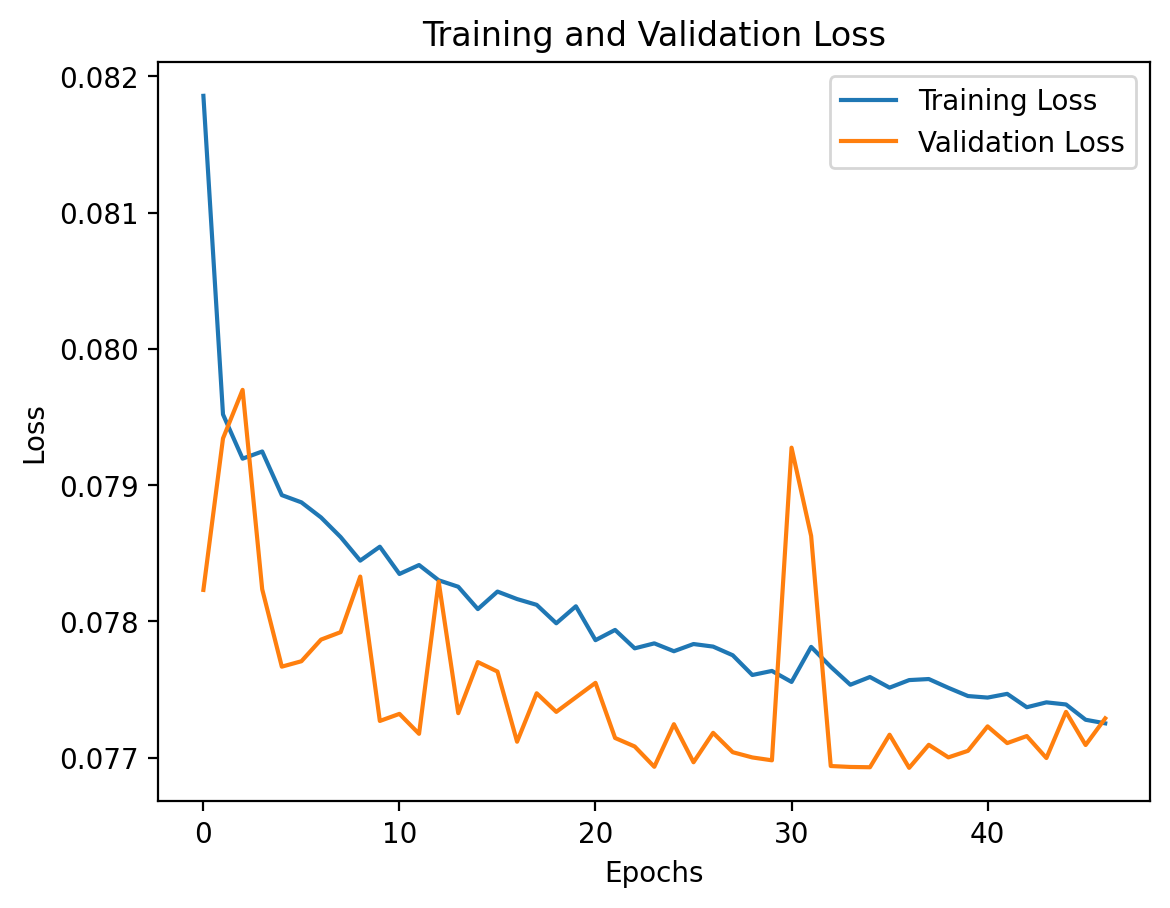

In [ ]:
# Visualisasi Loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
predictions = model.predict(X_val)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


In [ ]:
# Membalikkan skala prediksi
# Pertama, ambil ID perusahaan untuk dataset validasi
company_ids_val = df['Company ID'].iloc[len(df) - len(y_val):].values.reshape(-1, 1)  # Pastikan ini dua dimensi

# Gabungkan prediksi dengan ID perusahaan
predictions_with_ids = np.hstack((predictions, company_ids_val))  # Gabungkan dengan kolom ID perusahaan
predictions_inverse = scaler.inverse_transform(predictions_with_ids)  # Kembalikan skala prediksi

# Kembalikan skala data aktual
y_val_actual = scaler.inverse_transform(np.hstack((y_val.reshape(-1, 1), company_ids_val)))

# Memisahkan hasil prediksi dan ID perusahaan
predicted_prices = predictions_inverse[:, 0]  # Ambil harga prediksi
actual_prices = y_val_actual[:, 0]  # Ambil harga aktual

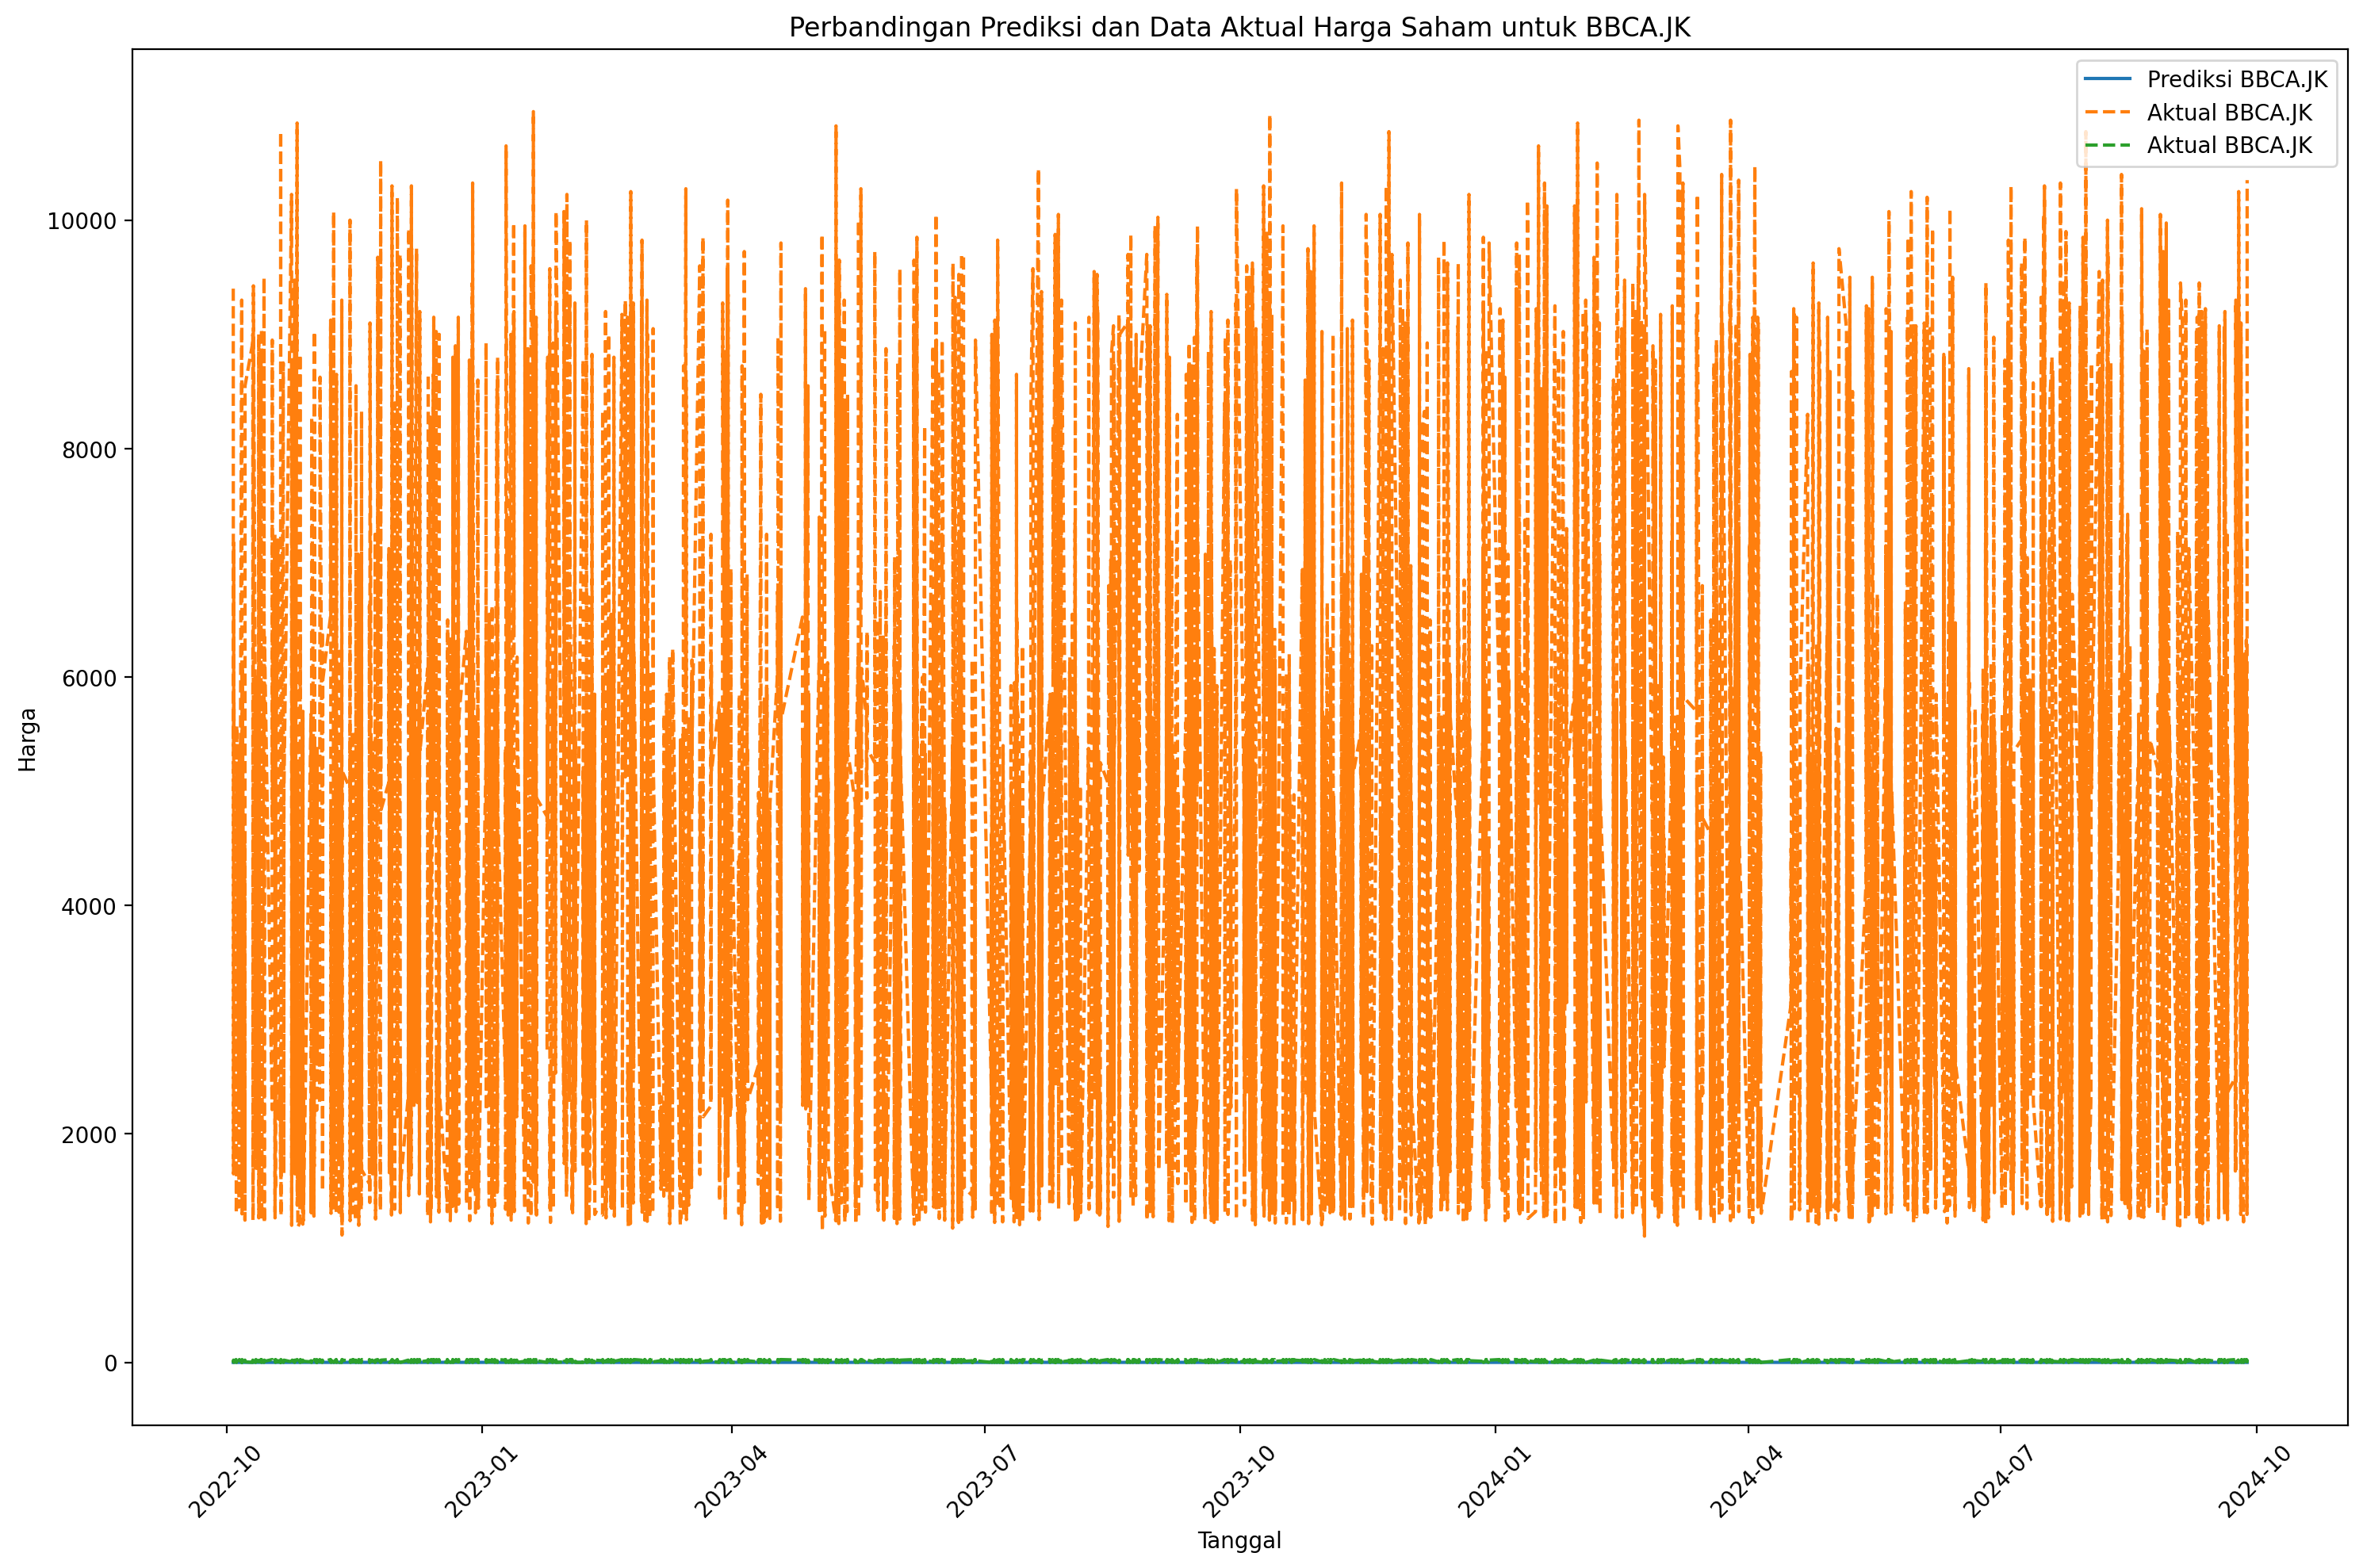

In [ ]:
import matplotlib.pyplot as plt

# Pilih perusahaan yang ingin ditampilkan
selected_company = 'BBCA.JK'

# Membuat grafik untuk perusahaan yang dipilih
plt.figure(figsize=(15, 10))

# Mengambil data untuk perusahaan ini
company_mask = df['Company'] == selected_company

# Mengambil indeks untuk data yang relevan
relevant_index = df[company_mask].index[-len(predictions):]

# Plot prediksi dan data aktual
plt.plot(df['Datetime'][relevant_index], predictions[relevant_index - df[company_mask].index[0]], label=f'Prediksi {selected_company}')
plt.plot(df['Datetime'][relevant_index], y_val_actual[relevant_index - df[company_mask].index[0]], label=f'Aktual {selected_company}', linestyle='--')

plt.title(f'Perbandingan Prediksi dan Data Aktual Harga Saham untuk {selected_company}')
plt.xlabel('Tanggal')
plt.ylabel('Harga')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
